In [148]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_theme()
from importlib import reload
from statsmodels.tools.sm_exceptions import EstimationWarning, ConvergenceWarning

# Silencing some pandas and statsmodels warnings
import warnings
warnings.filterwarnings("ignore", message="Could not infer format")
warnings.filterwarnings("ignore", message="Estimation of VARMA(p,q) models is not generically robust")
warnings.filterwarnings("ignore", message="Non-stationary starting autoregressive parameters found. Using zeros as starting parameters")
warnings.simplefilter("ignore", category=EstimationWarning)
warnings.simplefilter("ignore", category=ConvergenceWarning)

pd.set_option('max_colwidth', 400)

stocks = pd.read_csv("trading_data/stocks_cleaned.csv", parse_dates=["Traded", "Filed", "Quarter"])
test = stocks[stocks.Quarter >= "2023-01-01"]
train = stocks[stocks.Quarter < pd.to_datetime("2023-01-01")]

## Are the stock trades white noise?

Many of the trading graphs show little obvious structure beyond a slight trend. A reasonable null hypothesis is that log(gross trading) is follows a linear trend with normal residuals, possibly with parameters depending on the industry. There are two reasons to take the log: first, because gross trading is inherently nonnegative; second, because the trading data came to us bucketed by order of magnitude.

There are a few tests for normality of the residuals we can use:
- **Autocorrelation tests**: For white noise, the $k$th autocorrelation coefficient $\widehat{\rho}_k$ is normally distributed with mean 0 and standard deviation $\frac{1}{\sqrt{n}}\sigma_x$, where $\sigma_x$ is the standard deviation of the time series and $n$ is its length.
- **Ljung-Box Q-test**: ([Wikipedia](https://en.wikipedia.org/wiki/Ljung%E2%80%93Box_test)) This uses the test statistic $$Q = n(n+2)\sum_{k=1}^H \frac{\widehat{\rho}_k^2}{n-k}.$$ Under the null hypothesis that the data is normally distributed, $Q \sim \chi_{H}^2$.
- **Breusch-Godfrey test**: ([Wikipedia](https://en.wikipedia.org/wiki/Breusch%E2%80%93Godfrey_test)) This is essentially an F-test for nontriviality of the coefficients in an autoregressive model.

In [56]:
acf_results = acf(stock_log_gross["log_gross"], alpha=0.05, qstat=True)
pd.DataFrame({
    "ACF": acf_results[0],
    "

(array([ 1.        ,  0.59322191,  0.36675769,  0.16540381,  0.2142223 ,
         0.18453171,  0.24770879,  0.27185567,  0.17191098,  0.02864648,
         0.00382902,  0.02534542, -0.04052787, -0.06808438, -0.10439061,
        -0.1169788 ]),
 array([[ 1.        ,  1.        ],
        [ 0.26656124,  0.91988257],
        [-0.05963452,  0.79314991],
        [-0.29341745,  0.62422506],
        [-0.25091814,  0.67936273],
        [-0.29102004,  0.66008346],
        [-0.23542333,  0.7308409 ],
        [-0.22464375,  0.76835509],
        [-0.34022589,  0.68404784],
        [-0.48961146,  0.54690441],
        [-0.51459784,  0.52225589],
        [-0.49308447,  0.5437753 ],
        [-0.55908997,  0.47803422],
        [-0.58698435,  0.45081559],
        [-0.62424296,  0.41546173],
        [-0.6390632 ,  0.4051056 ]]),
 array([13.75474084, 19.16683873, 20.30096959, 22.26281809, 23.76549775,
        26.56349751, 30.04979865, 31.49369258, 31.53527069, 31.53604211,
        31.5711937 , 31.66481669, 

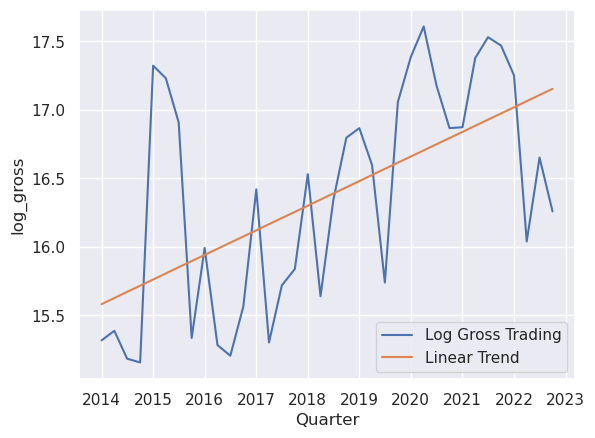

In [63]:
from sklearn.linear_model import LinearRegression

stock_gross = train.groupby("Quarter")[["Min_Trade_Size"]].sum().rename(columns={"Min_Trade_Size": "gross"})
stock_gross["log_gross"] = np.log1p(stock_gross["gross"])
stock_gross["time_idx"] = np.arange(len(stock_gross))
trend = LinearRegression().fit(stock_gross[["time_idx"]], stock_gross["log_gross"])
stock_gross["trend"] = trend.predict(stock_gross[["time_idx"]])
sns.lineplot(stock_gross["log_gross"], label="Log Gross Trading")
sns.lineplot(stock_gross["trend"], ax=plt.gca(), label="Linear Trend");

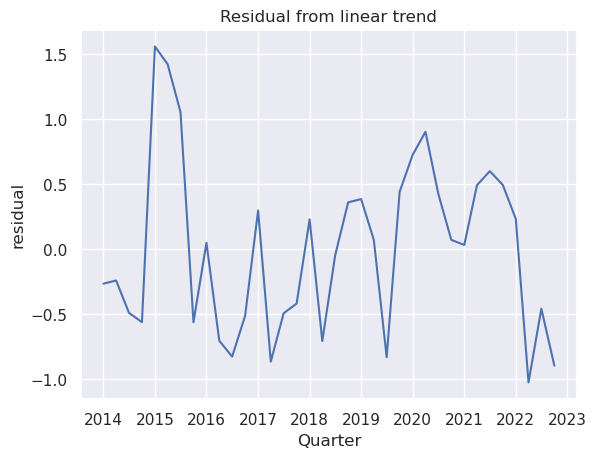

In [64]:
stock_log_gross["residual"] = stock_log_gross["log_gross"] - stock_log_gross["trend"]
sns.lineplot(stock_log_gross["residual"])
plt.title("Residual from linear trend");

In [70]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf
from statsmodels.stats.diagnostic import acorr_ljungbox, acorr_breusch_godfrey
from scipy import stats
def white_noise_test_suite(x, nlags=10):
    n = len(x)
    nlags = min(n, nlags)
    lin_inputs = np.vstack([np.ones(n), np.arange(n)]).T
    lin_trend = OLS(x, lin_inputs).fit()
    
    # Breusch-Godfrey test
    _, lpval, _, fpval = acorr_breusch_godfrey(lin_trend, nlags=nlags)
    
    # Ljung-Box test
    x_pred = lin_trend.get_prediction(lin_inputs).predicted_mean
    x_detrend = x - x_pred
    lbpvals = acorr_ljungbox(x_detrend, lags=nlags)["lb_pvalue"]
    
    print(f"Breusch-Godfrey Lagrange multiplier test p-value: {lpval:.3f}, F-test p-value: {fpval:.3f}")
    print("Ljung-Box p-values:")
    print(lbpvals)
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    sns.lineplot(x, label="Observed", ax=axs[0])
    sns.lineplot(pd.Series(x_pred, index=x.index), label="Linear Trend", ax=axs[0])
    axs[0].set_title("Linear model")
    plot_acf(x_detrend, ax=axs[1])
    axs[1].set_title("ACF of detrended data")
    

Breusch-Godfrey Lagrange multiplier test p-value: 0.033, F-test p-value: 0.017
Ljung-Box p-values:
1     0.000749
2     0.002786
3     0.002900
4     0.006303
5     0.013232
6     0.021854
7     0.038560
8     0.034371
9     0.010464
10    0.003534
Name: lb_pvalue, dtype: float64


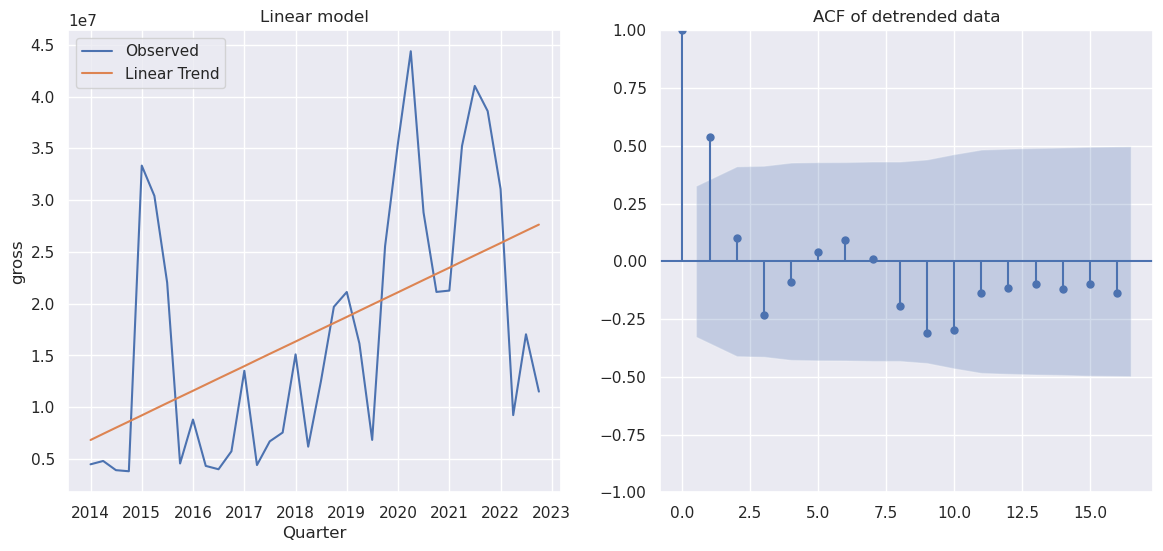

In [71]:
white_noise_test_suite(stock_gross["gross"])

Breusch-Godfrey Lagrange multiplier test p-value: 0.230, F-test p-value: 0.267
Ljung-Box p-values:
1     0.013311
2     0.040599
3     0.041682
4     0.079499
5     0.110256
6     0.172629
7     0.251306
8     0.313519
9     0.164694
10    0.119241
Name: lb_pvalue, dtype: float64


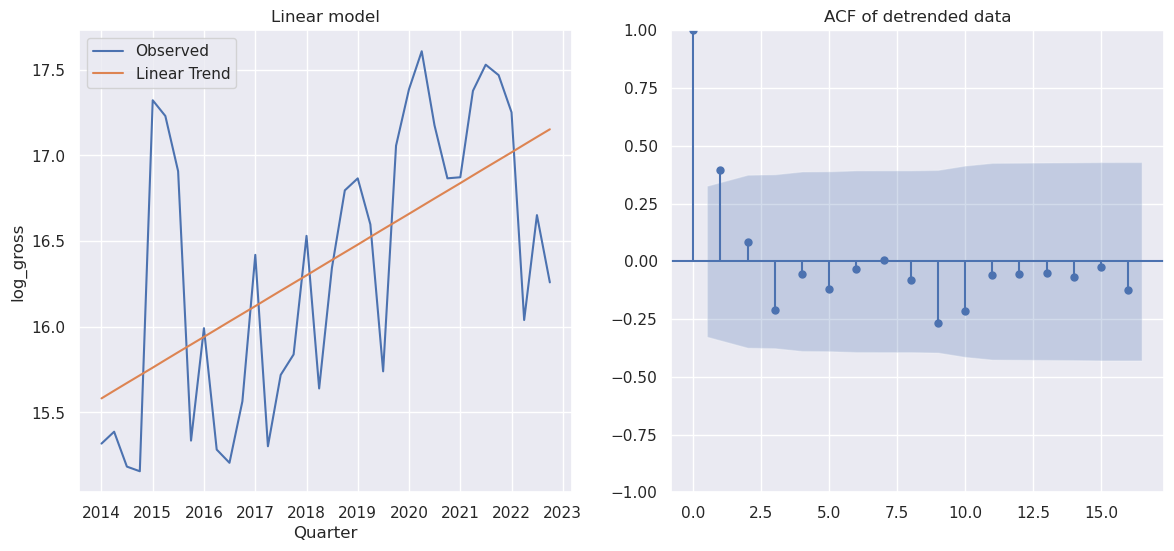

In [72]:
white_noise_test_suite(stock_gross["log_gross"])

In my view, these results do not give cause to reject the linear model. The single significant autocorrelation at lag 1 is just on the edge of significance, and similarly, while the Ljung-Box test shows some significant p-values for small values of H, they are not overwhelming and are not preserved at larger values of H.

Let's examine some results from specific industries.

codes                          [ADV]
industries    [Advertising Agencies]
Name: 0, dtype: object
Breusch-Godfrey Lagrange multiplier test p-value: 0.159, F-test p-value: 0.171
Ljung-Box p-values:
1     0.389610
2     0.078406
3     0.140794
4     0.118707
5     0.101608
6     0.145980
7     0.206515
8     0.232704
9     0.303914
10    0.111621
Name: lb_pvalue, dtype: float64

codes                                                                             [AGR]
industries    [Agricultural Inputs, Farm & Heavy Construction Machinery, Farm Products]
Name: 1, dtype: object
Breusch-Godfrey Lagrange multiplier test p-value: 0.151, F-test p-value: 0.161
Ljung-Box p-values:
1     0.936776
2     0.599579
3     0.590165
4     0.561479
5     0.692124
6     0.703594
7     0.023442
8     0.038748
9     0.027929
10    0.030532
Name: lb_pvalue, dtype: float64

codes                    [AER, DEF]
industries    [Aerospace & Defense]
Name: 2, dtype: object
Breusch-Godfrey Lagrange multiplier test p-va

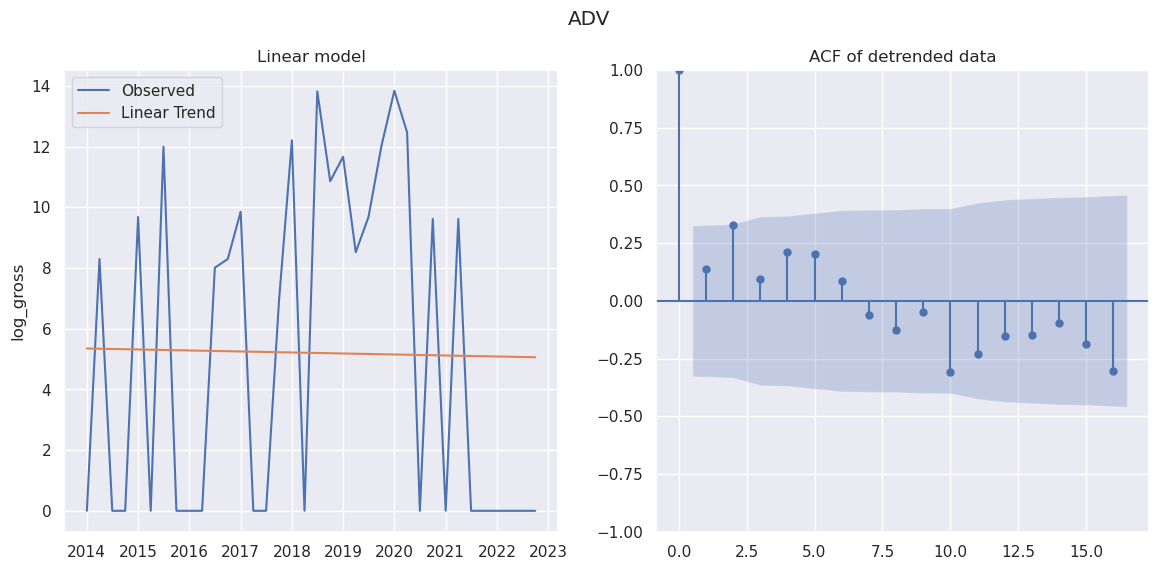

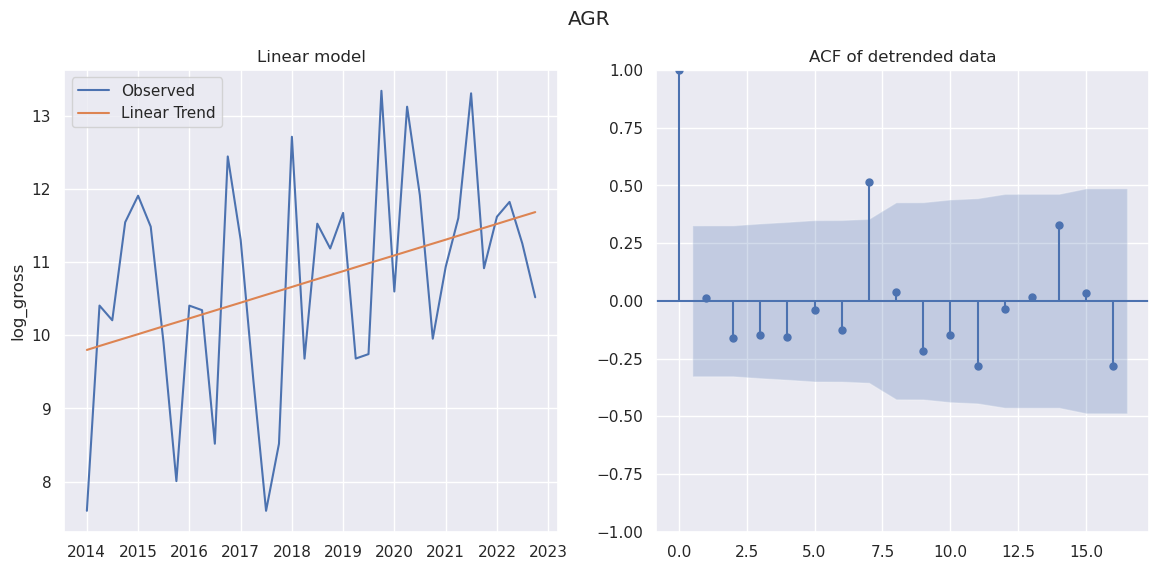

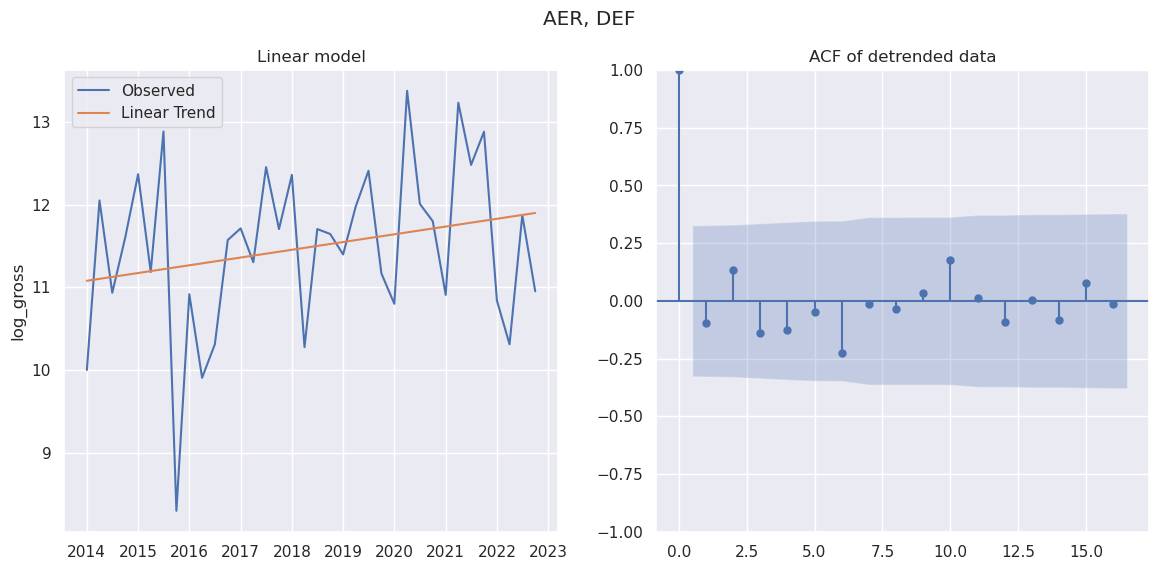

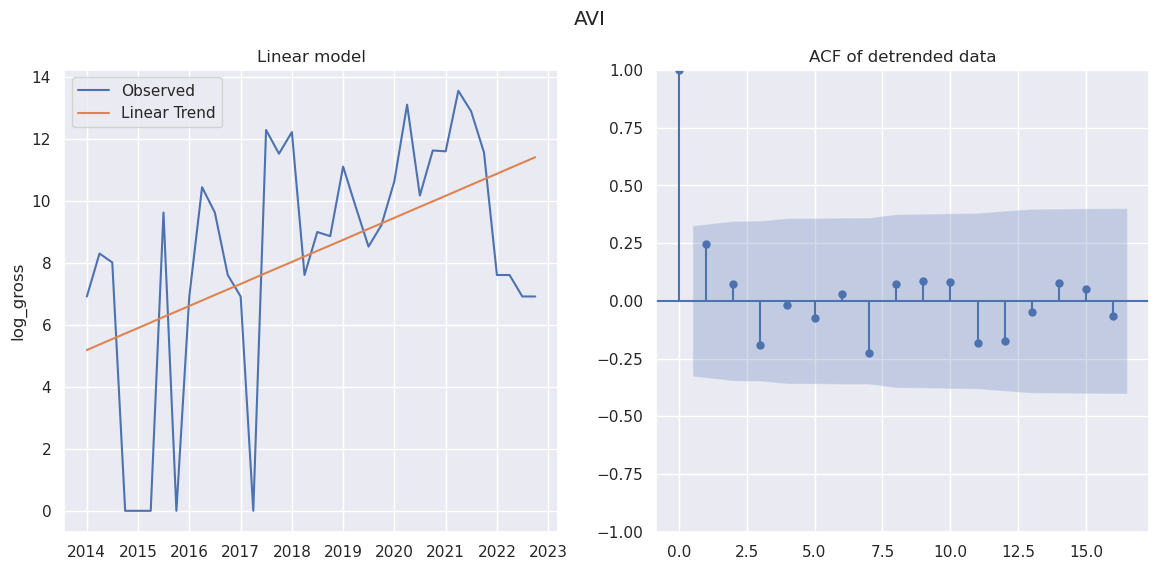

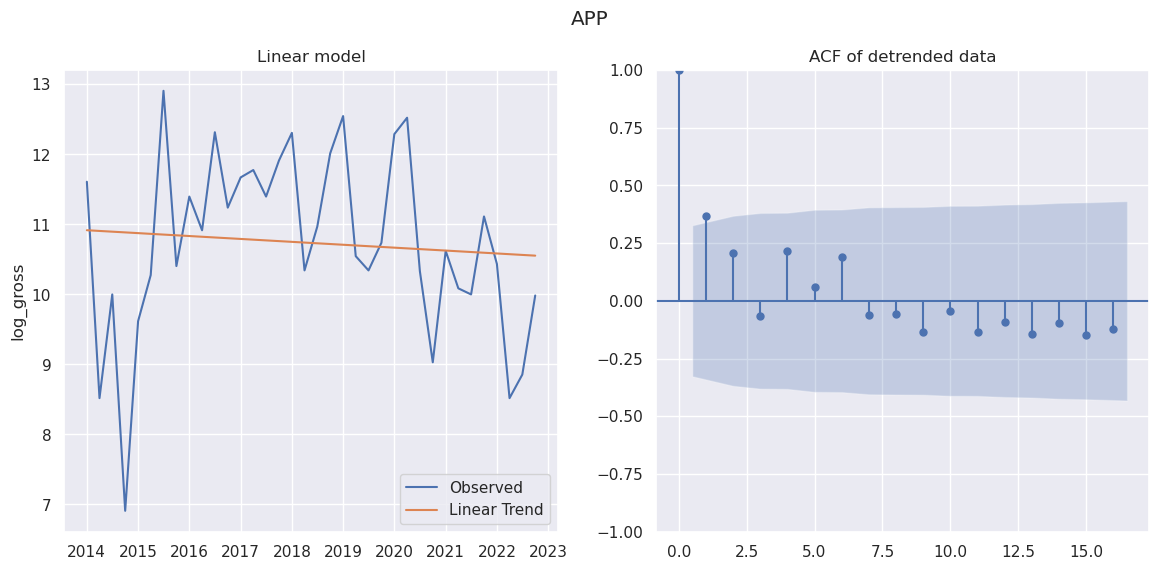

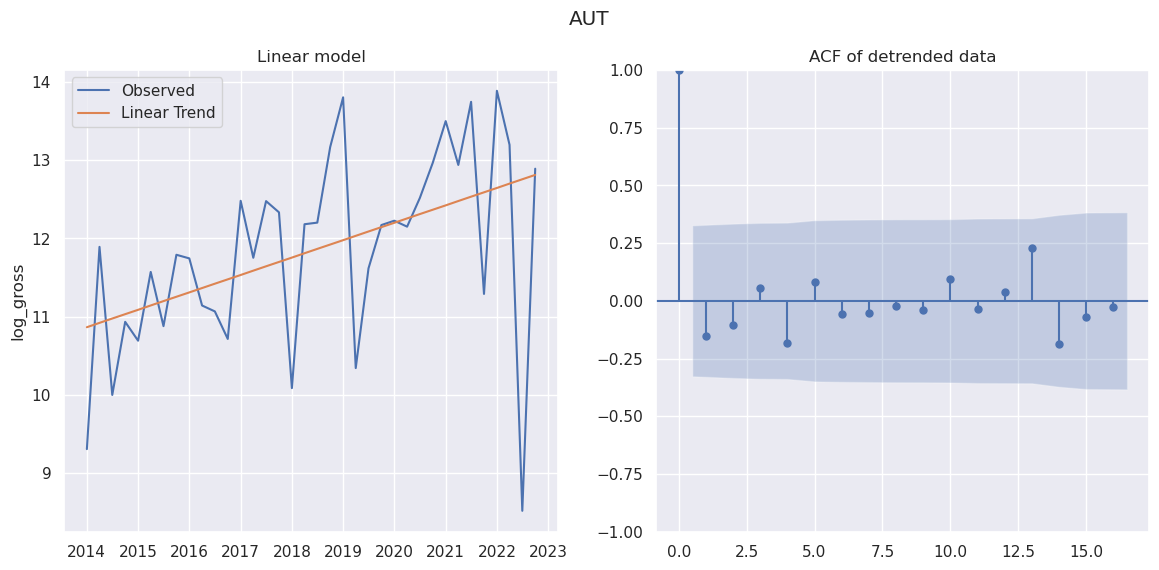

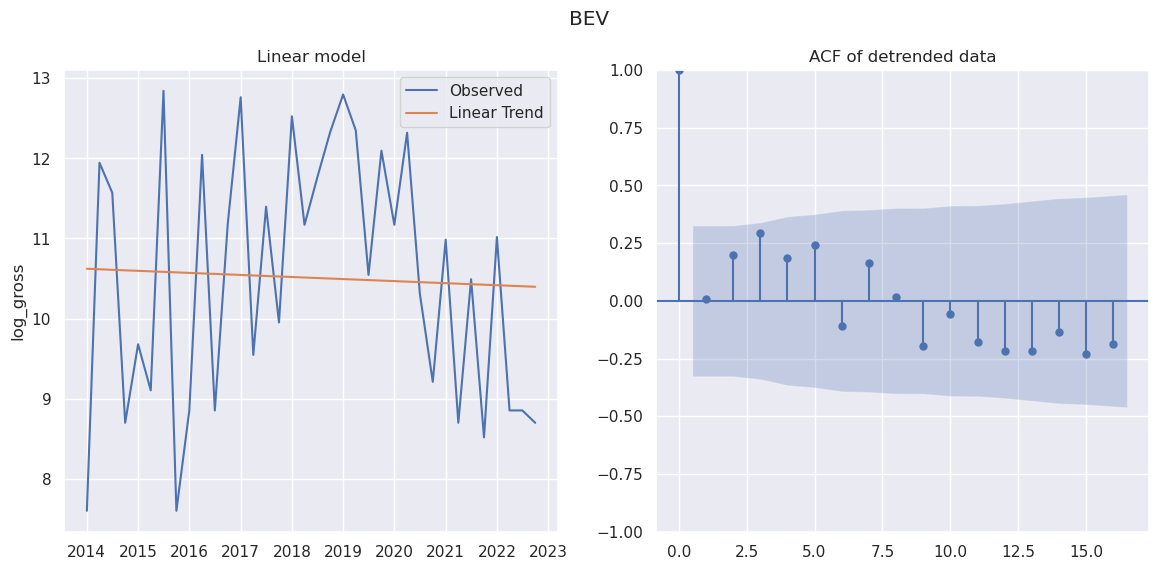

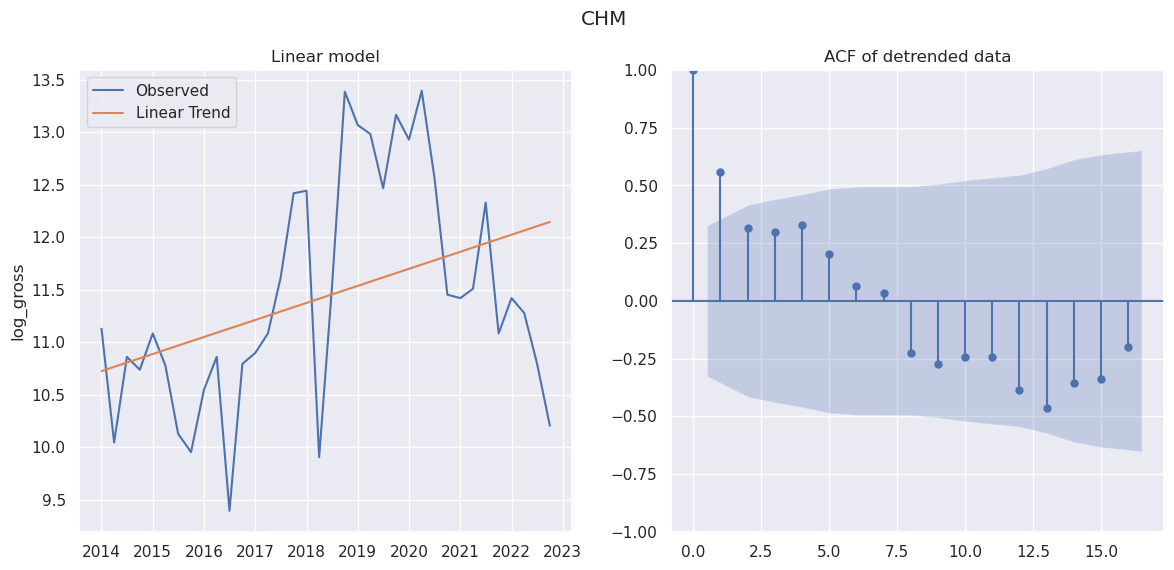

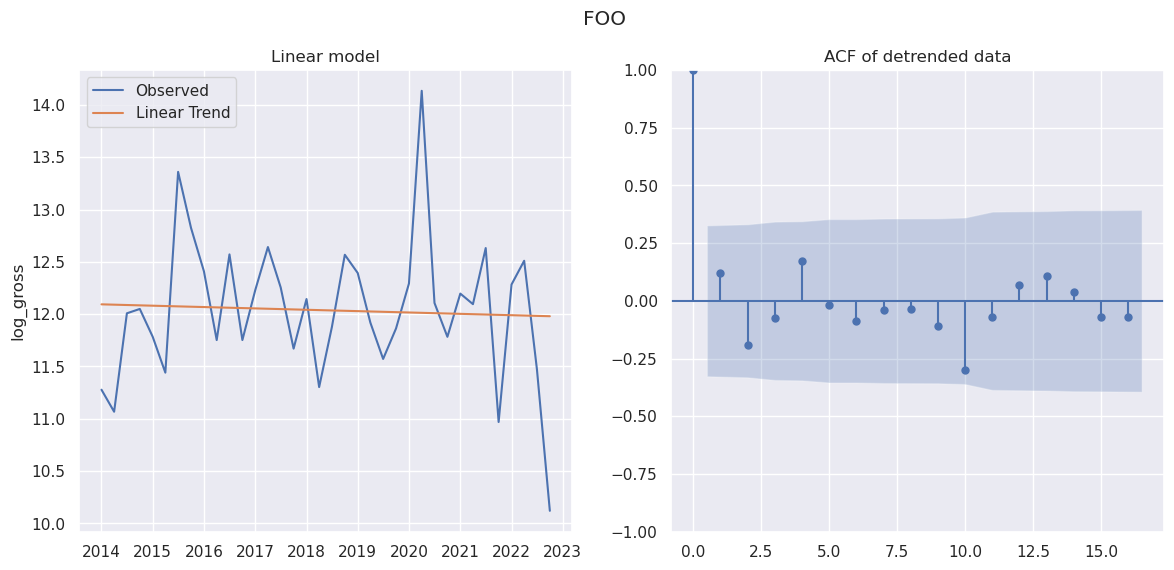

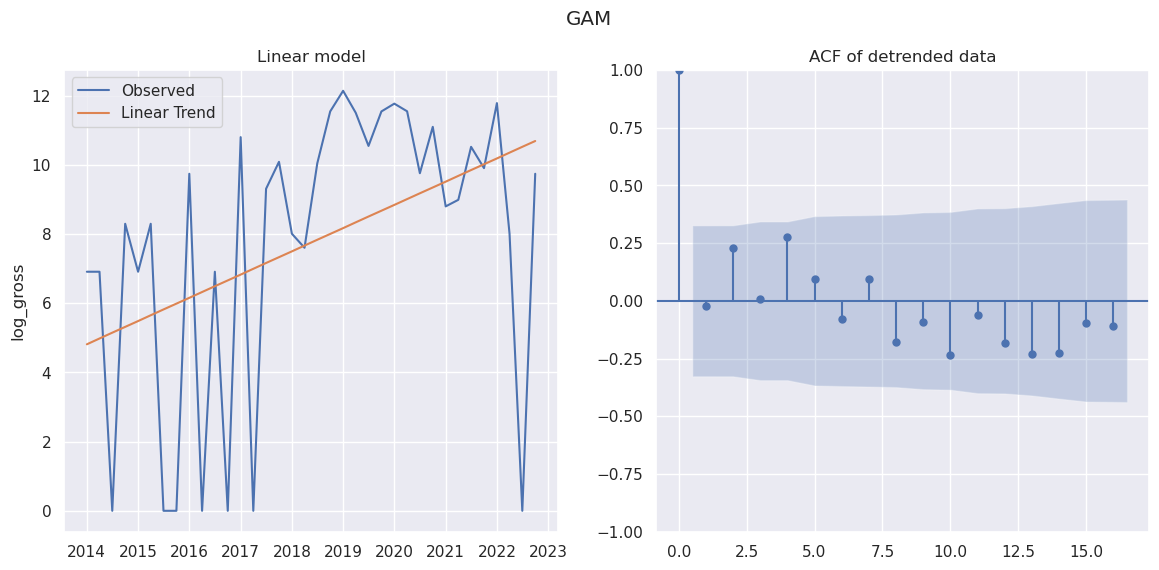

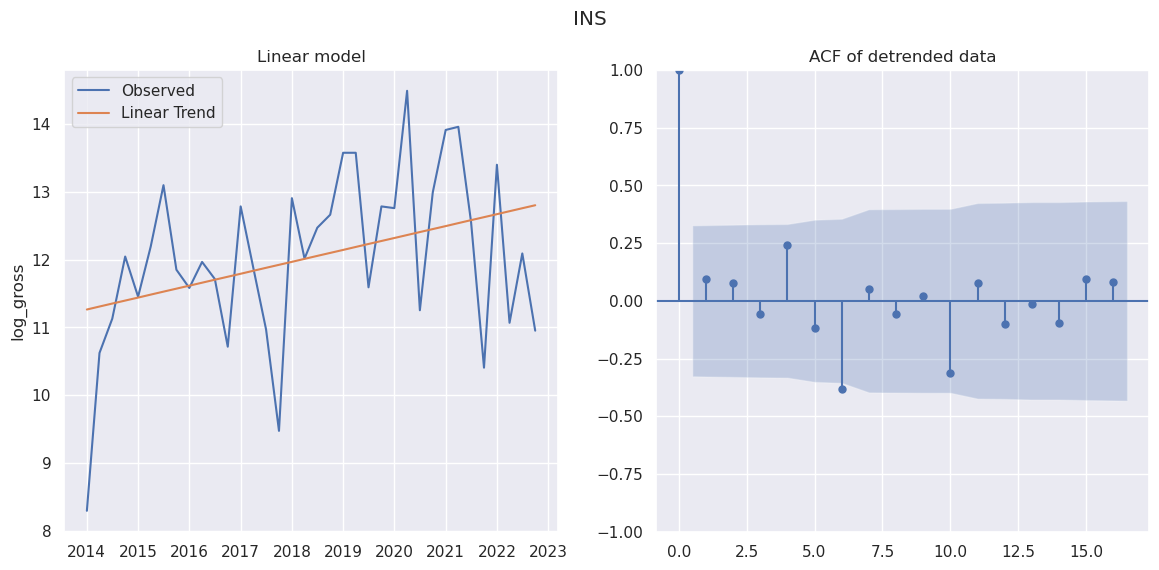

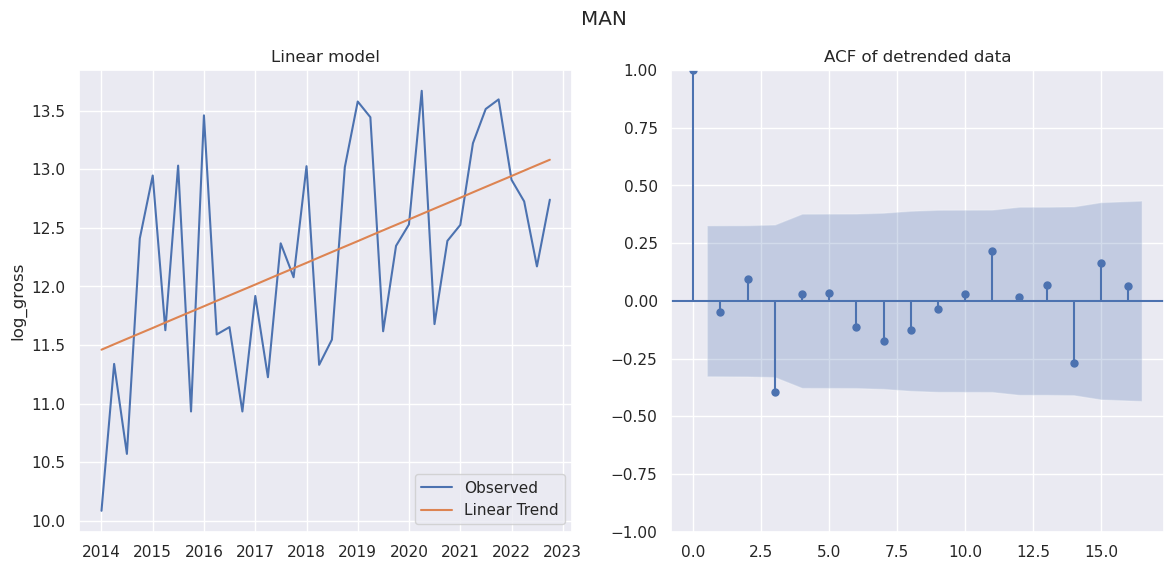

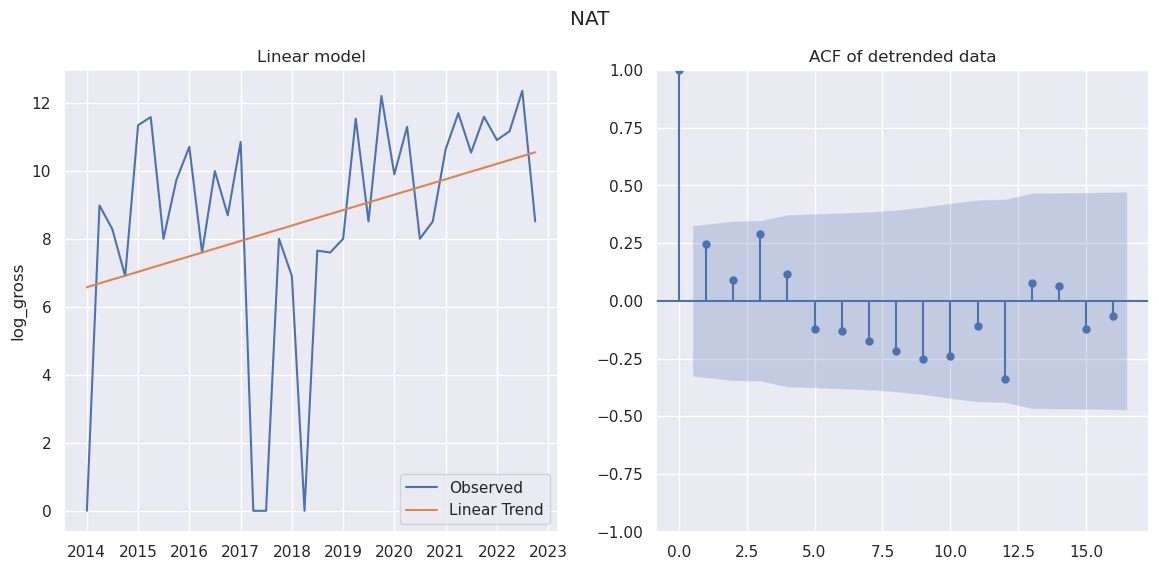

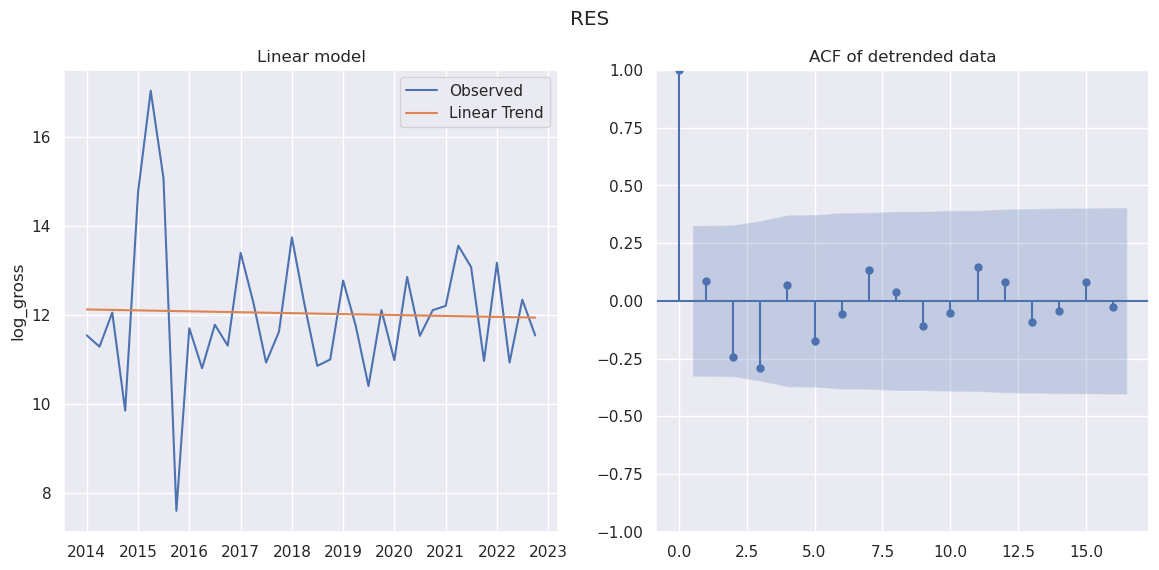

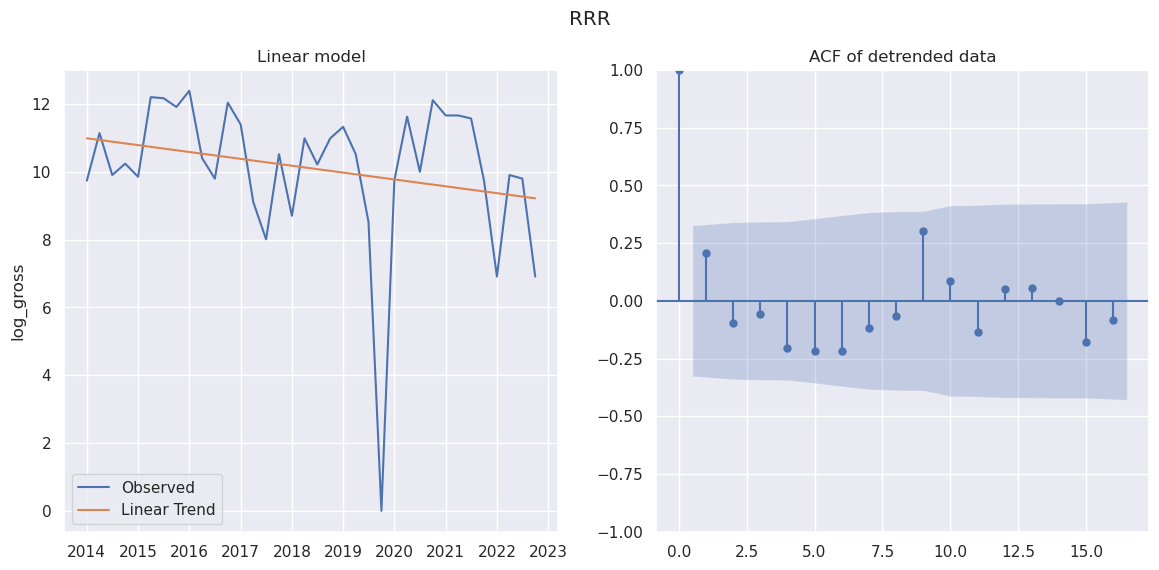

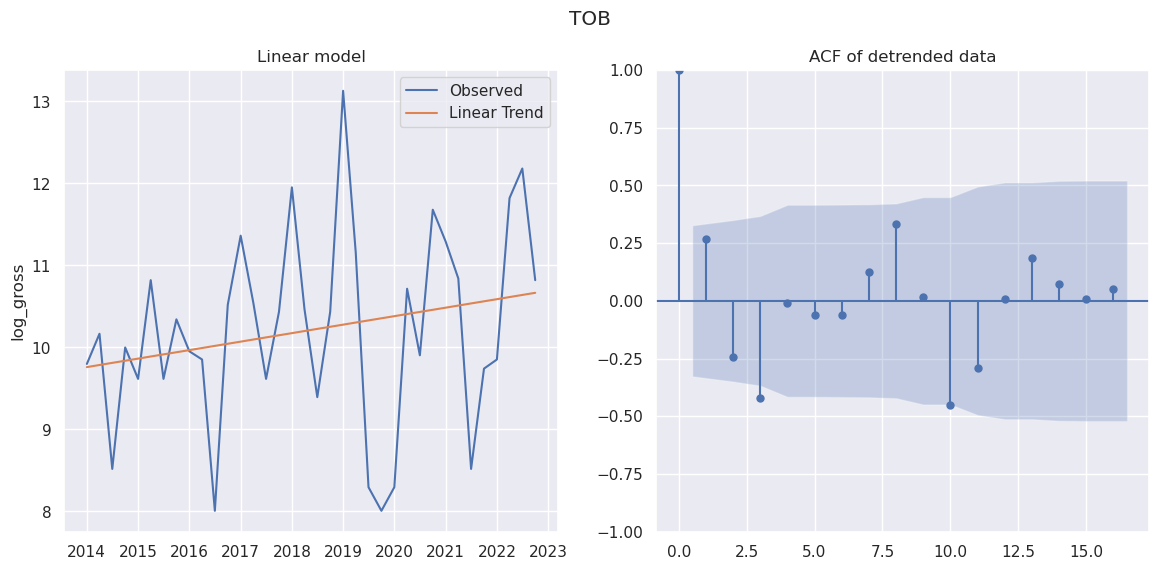

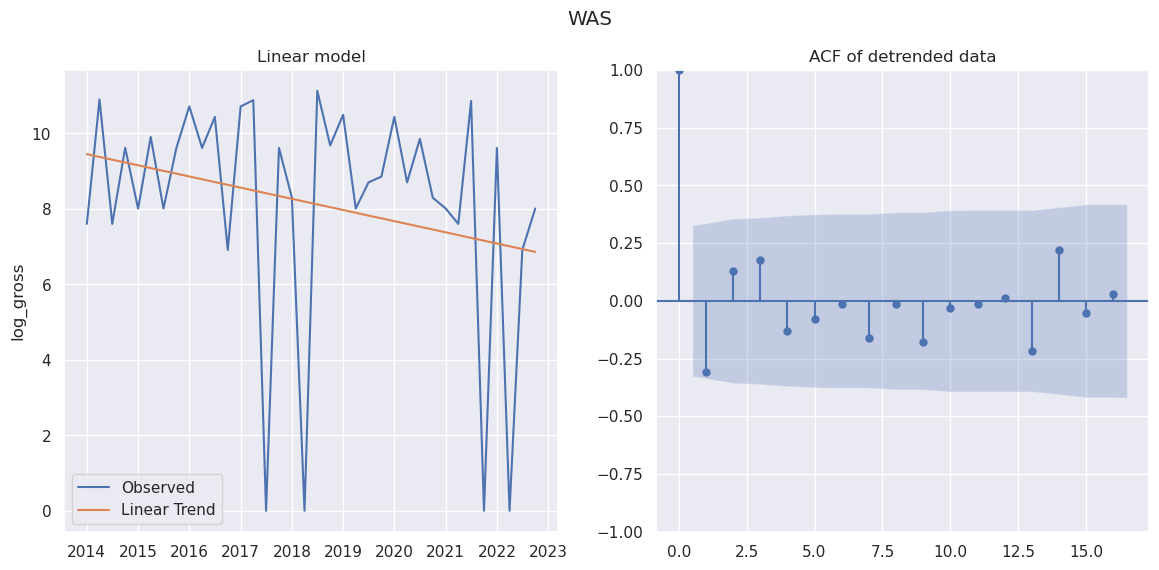

In [77]:
from scripts.data_extraction import stock_totals
code2sector = pd.read_csv("trading_data/lobbyingcode2sector.csv").applymap(eval)

for idx in range(len(code2sector)):
    industry_totals = stock_totals(code2sector.loc[idx, "industries"])
    # Exclude early dates for which there's no data
    industry_totals = industry_totals[industry_totals.index > pd.to_datetime("2013-12-31")]
    industry_totals["log_gross"] = np.log1p(industry_totals["stocks_gross"])
    print(code2sector.loc[idx])
    white_noise_test_suite(industry_totals["log_gross"])
    plt.gcf().suptitle(", ".join(code2sector.loc[idx, 'codes']))
    print()
    

Low p-values only appear in two industries: chemicals and tobacco. Let's examine these more closely.

In [87]:
chem = stocks[stocks.Industry.isin(["Chemicals", "Specialty Chemicals"])]
chem["Name"].value_counts()

Name
David Perdue              110
Greg Gianforte             55
Alan S. Lowenthal          53
Lois Frankel               47
Josh Gottheimer            41
                         ... 
Marjorie Taylor Greene      1
John A. Boehner             1
Angus King                  1
Michael John Gallagher      1
Deborah K. Ross             1
Name: count, Length: 93, dtype: int64

In [88]:
chem.sort_values(by="Min_Trade_Size", ascending=False).head()

,Ticker,TickerType,Company,Traded,Transaction,Subholding,Description,Name,Filed,Party,...,Min_Trade_Size,Max_Trade_Size,Quarter,Sector,Industry,YFQuoteType,Category1,Category2,Category3,Codes
19587,FUPBY,ST,FUCHS PETROLUB SE UNSPONSORED AMERICAN DEPOSITORY RECEIPTREPRESENTING PREFERENCED SHARES,2019-10-11,Purchase,HARDING LOEVNER INTERNATIONAL EQUITY,NaN,Greg Gianforte,2019-11-27,R,...,100001.0,250000.0,2019-10-01,Basic Materials,Specialty Chemicals,EQUITY,CHM,NaN,NaN,CHM
21342,DD,ST,"DuPont de Nemours, Inc.",2020-02-28,Purchase,NaN,NaN,Kelly Loeffler,2020-03-31,R,...,100001.0,250000.0,2020-01-01,Basic Materials,Specialty Chemicals,EQUITY,CHM,NaN,NaN,CHM
24723,IFF,ST,"INTERNATIONA FLAVORS & FRAGRANCES, INC.",2020-07-28,Sale,RIVERBRIDGE MANAGED ACCOUNT - SMALL CAP US EQUITIES,NaN,Greg Gianforte,2020-08-03,R,...,100001.0,250000.0,2020-07-01,Basic Materials,Specialty Chemicals,EQUITY,CHM,NaN,NaN,CHM
15771,NVZMY,ST,NOVOZYMES A/S UNSPONSORED AMERICAN DEPOSITARY RECEIPT,2018-12-21,Purchase,HARDING LOEVNER INTERNATIONAL EQUITY,NaN,Greg Gianforte,2019-01-23,R,...,100001.0,250000.0,2019-01-01,Basic Materials,Specialty Chemicals,EQUITY,CHM,NaN,NaN,CHM
29470,LIN,ST,LINDE PLC ORDINARY SHARE,2021-06-25,Purchase,HERN FAMILY REVOCABLE TRUST > BROKERAGE INVESTMENT ACCOUNT,NaN,Kevin Hern,2021-07-14,R,...,100001.0,250000.0,2021-07-01,Basic Materials,Specialty Chemicals,EQUITY,CHM,NaN,NaN,CHM


<Axes: >

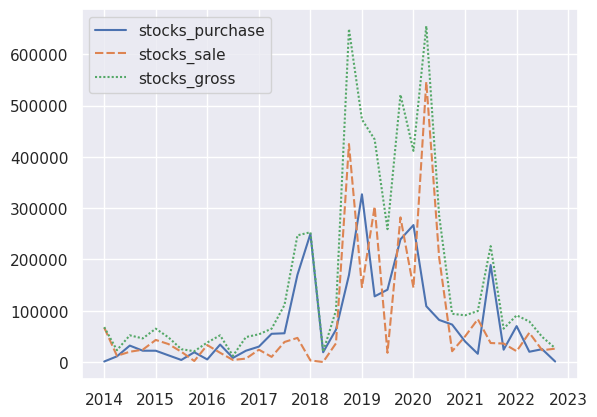

In [91]:
chem_totals = stock_totals(["Chemicals", "Specialty Chemicals"])
chem_totals = chem_totals[chem_totals.index >= pd.to_datetime("2014-01-01")]
sns.lineplot(chem_totals[["stocks_purchase", "stocks_sale", "stocks_gross"]])

## Baseline models for stocks

I'll consider two baseline models for log(gross stock trading): a linear trend with white noise, and a random walk with drift. Each category of stock under consideration will be modelled independently, and we'll score the models using cross-validation mean squared error. The null hypothesis is that we can't beat these baseline models using information from the lobbying data.

In [3]:
# Using Rahul's modifications to the code2sector assignment
code2sector = pd.read_csv("trading_data/lobbyingcode2sector_v2.csv", index_col="codes")
code2sector.industries = code2sector.industries.map(eval)
code2sector

,industries
codes,
ADV,[Advertising Agencies]
AGR,"[Agricultural Inputs, Farm & Heavy Construction Machinery, Farm Products]"
AUT,"[Auto & Truck Dealerships, Auto Manufacturers, Auto Parts, Recreational Vehicles]"
BEV,"[Beverages - Brewers, Beverages - Non-Alcoholic, Beverages - Wineries & Distilleries]"
CHM,"[Chemicals, Specialty Chemicals]"
DEF,[Aerospace & Defense]
EDU,[Education & Training Services]
ENG,[Solar]
FOO,"[Confectioners, Food Distribution, Packaged Foods]"


In [52]:
dict(code2sector)

{'industries': codes
 ADV                                                                                                                                                   [Advertising Agencies]
 AGR                                                                                                [Agricultural Inputs, Farm & Heavy Construction Machinery, Farm Products]
 AUT                                                                                        [Auto & Truck Dealerships, Auto Manufacturers, Auto Parts, Recreational Vehicles]
 BEV                                                                                    [Beverages - Brewers, Beverages - Non-Alcoholic, Beverages - Wineries & Distilleries]
 CHM                                                                                                                                         [Chemicals, Specialty Chemicals]
 DEF                                                                                                         

<Axes: ylabel='stocks_gross'>

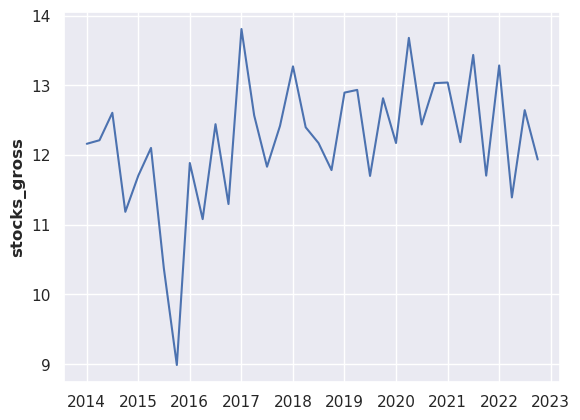

In [76]:
from scripts.data_extraction import stock_totals
RES_totals = stock_totals(code2sector.loc["RES"].industries).iloc[4:]
sns.lineplot(np.log(RES_totals["stocks_gross"]))

58677792077.03914

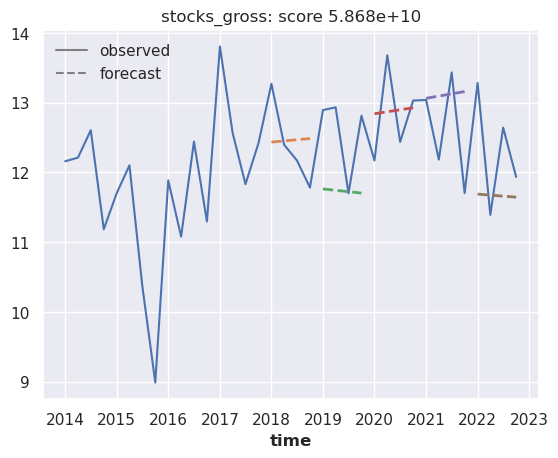

In [77]:
import scripts.model_evaluation
reload(scripts.model_evaluation)
from scripts.model_evaluation import cross_validate
from darts.models import NaiveDrift

def mse_for_log_model(y_true, y_pred):
    """Given two logged series, get the mean squared error for the unlogged
    predictions.
    """
    y_true, y_pred = np.asarray(y_true.values()).flatten(), np.asarray(y_pred.values()).flatten()
    return ((np.exp(y_true) - np.exp(y_pred))**2).mean()

cross_validate(NaiveDrift(), np.log(RES_totals["stocks_gross"]), metric=mse_for_log_model)


/home/pvk/miniconda3/envs/ML/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


53629838352.36725

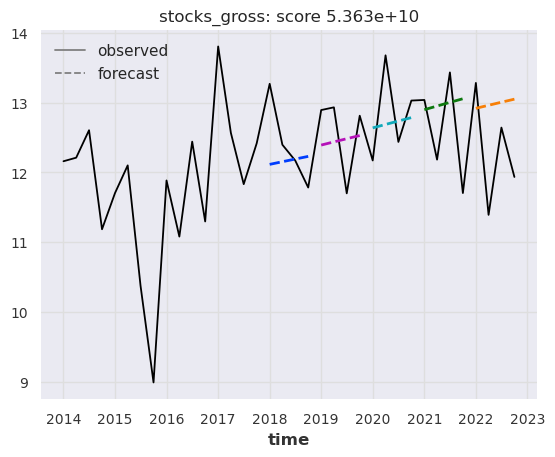

In [78]:
from darts.models import ARIMA
# Suppressing an error about too little training data
ARIMA.min_train_series_length = 10
cross_validate(ARIMA(p=0, d=0, q=0, trend="ct"), np.log(RES_totals["stocks_gross"]), metric=mse_for_log_model)

In [84]:
scores = pd.DataFrame(index=code2sector.index, columns=["Naive Drift", "Linear Trend"])
for code in code2sector.index:
    code_totals = stock_totals(code2sector.loc[code, "industries"]).iloc[4:]
    code_log_gross = np.log1p(code_totals["stocks_gross"])
    scores.loc[code, "Naive Drift"] = cross_validate(
        NaiveDrift(), code_log_gross, metric=mse_for_log_model, plot=False
    )
    scores.loc[code, "Linear Trend"] = cross_validate(
        ARIMA(p=0, d=0, q=0, trend="ct"), code_log_gross, metric=mse_for_log_model,
        plot=False
    )
pd.options.display.float_format = lambda x: f"{x.item():0.3e}"
scores

/home/pvk/miniconda3/envs/ML/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/pvk/miniconda3/envs/ML/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,Naive Drift,Linear Trend
codes,,
ADV,1.244e+12,9.314e+11
AGR,4.805e+11,1.396e+11
AUT,8.727e+11,5.403e+11
BEV,1.068e+11,1.200e+11
CHM,3.313e+11,3.374e+11
DEF,1.971e+11,1.230e+11
EDU,1.188e+13,3.734e+10
ENG,8.313e+10,3.744e+09
FOO,1.734e+11,1.401e+11


The linear trend usually outperforms the drift model, but both are within the same order of magnitude.

## VARIMA model

Here, we try to use a vector-valued ARIMA (VARIMA) to model the purchases and sales simultaneously.

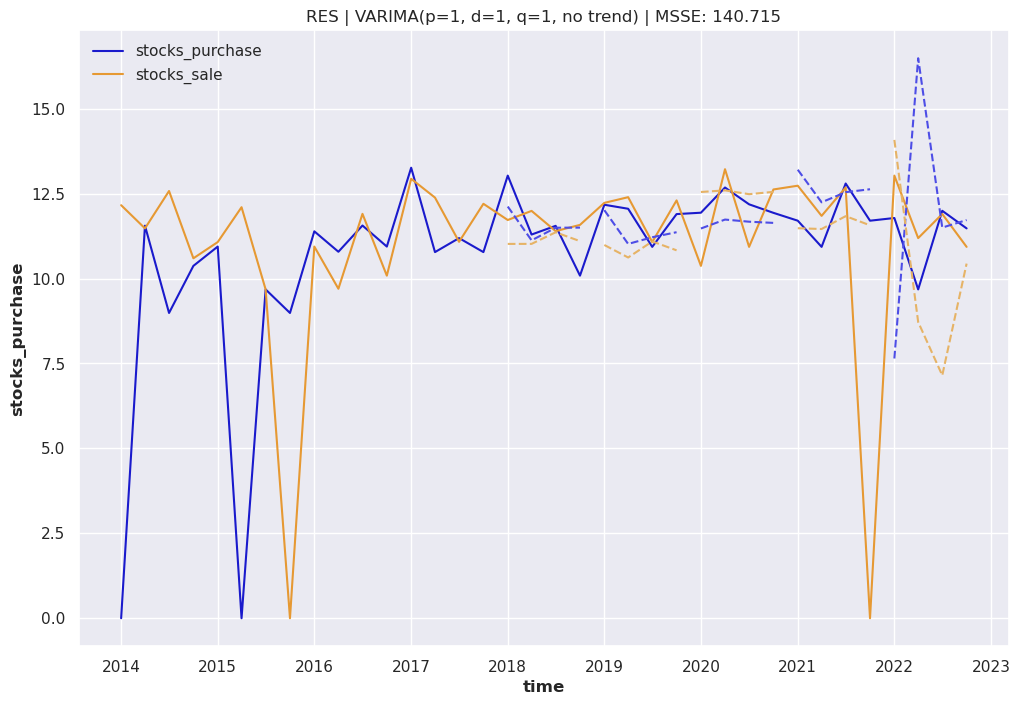

In [139]:
from sklearn.model_selection import TimeSeriesSplit
from darts import TimeSeries
from darts.models import VARIMA
from scripts.data_extraction import stock_totals

VARIMA.min_train_series_length = 15

trend_dict = {
    "n": "no trend",
    "ct": "linear trend",
}

def cross_validate_varima(code, p, d, q, trend, plot=True, n_cv=5, test_size=4, **varima_kwargs):

    kf = TimeSeriesSplit(n_splits=n_cv, test_size=test_size)
    code_totals = stock_totals(code2sector.loc[code, "industries"]).iloc[4:]
    X_df = np.log1p(code_totals[["stocks_purchase", "stocks_sale"]])

    if plot:
        fig, ax = plt.subplots(figsize=(12,8))
        sns.lineplot(X_df["stocks_purchase"], linestyle="solid", label="stocks_purchase", color=(0.1, 0.1, 0.8), ax=ax)
        sns.lineplot(X_df["stocks_sale"], linestyle="solid", label="stocks_sale", color=(0.9, 0.6, 0.2), ax=ax)

    MSSE = 0
    for train_idx, valid_idx in kf.split(X_df):
        X_train = TimeSeries.from_dataframe(X_df.iloc[train_idx])
        X_valid = TimeSeries.from_dataframe(X_df.iloc[valid_idx])

        try:
            model = VARIMA(p=p, d=d, q=q, trend=trend).fit(X_train)
        except Exception as e:
            print(f"{code}, {p}, {d}, {q}, {trend_dict[trend]}: {e}")
            return np.nan

        preds = model.predict(len(X_valid))
        MSSE += msse(X_valid.map(np.exp), preds.map(np.exp), X_train.map(np.exp), m=1)
        
        if plot:
            preds_df = preds.pd_dataframe().rename(columns=lambda x: x + "_preds")
            sns.lineplot(preds_df["stocks_purchase_preds"], linestyle="dashed", label=None, color=(0.3, 0.3, 0.9), ax=ax)
            sns.lineplot(preds_df["stocks_sale_preds"], linestyle="dashed", label=None, color=(0.9, 0.7, 0.4), ax=ax)

    MSSE /= kf.get_n_splits()
    if plot:
        plt.title(f"{code} | VARIMA({p=}, {d=}, {q=}, {trend_dict[trend]}) | MSSE: {MSSE:.3f}")
    return MSSE
        
cross_validate_varima("RES", 1, 1, 1, "n");

In [140]:
kf = TimeSeriesSplit(n_splits=5, test_size=4)
scores = pd.DataFrame()
for code in code2sector.index:
    for p in range(3):
        for q in range(3):
            if p == 0 and q == 0:
                continue
            for d, trend in [(0, "ct"), (1, "n")]:
                model_name = f"VARIMA({p=}, {d=}, {q=}, {trend_dict[trend]})"
                scores.loc[code, model_name] = cross_validate_varima(code, p, d, q, trend, plot=False)

/home/pvk/miniconda3/envs/ML/lib/python3.10/site-packages/statsmodels/tsa/statespace/varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/pvk/miniconda3/envs/ML/lib/python3.10/site-packages/statsmodels/tsa/statespace/varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/pvk/miniconda3/envs/ML/lib/python3.10/site-packages/statsmodels/tsa/statespace/varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/pvk/miniconda3/envs/ML/lib/python3.10/site-packages/statsmodels/tsa/statespace/varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

GAM, 0, 0, 1, linear trend: Matrix is not positive definite
GAM, 0, 1, 1, no trend: Matrix is not positive definite
GAM, 0, 0, 2, linear trend: Matrix is not positive definite
GAM, 0, 1, 2, no trend: Matrix is not positive definite
GAM, 1, 0, 0, linear trend: Matrix is not positive definite
GAM, 1, 1, 0, no trend: Matrix is not positive definite
GAM, 1, 0, 1, linear trend: Matrix is not positive definite
GAM, 1, 1, 1, no trend: Matrix is not positive definite
GAM, 1, 0, 2, linear trend: Matrix is not positive definite
GAM, 1, 1, 2, no trend: Matrix is not positive definite
GAM, 2, 0, 0, linear trend: Matrix is not positive definite
GAM, 2, 1, 0, no trend: Matrix is not positive definite
GAM, 2, 0, 1, linear trend: Matrix is not positive definite
GAM, 2, 1, 1, no trend: Matrix is not positive definite
GAM, 2, 0, 2, linear trend: Matrix is not positive definite
GAM, 2, 1, 2, no trend: Matrix is not positive definite


In [141]:
scores.style.highlight_min(color="darkblue", axis=1)

,"VARIMA(p=0, d=0, q=1, linear trend)","VARIMA(p=0, d=1, q=1, no trend)","VARIMA(p=0, d=0, q=2, linear trend)","VARIMA(p=0, d=1, q=2, no trend)","VARIMA(p=1, d=0, q=0, linear trend)","VARIMA(p=1, d=1, q=0, no trend)","VARIMA(p=1, d=0, q=1, linear trend)","VARIMA(p=1, d=1, q=1, no trend)","VARIMA(p=1, d=0, q=2, linear trend)","VARIMA(p=1, d=1, q=2, no trend)","VARIMA(p=2, d=0, q=0, linear trend)","VARIMA(p=2, d=1, q=0, no trend)","VARIMA(p=2, d=0, q=1, linear trend)","VARIMA(p=2, d=1, q=1, no trend)","VARIMA(p=2, d=0, q=2, linear trend)","VARIMA(p=2, d=1, q=2, no trend)"
ADV,121.879062,121.872111,121.851662,121.873963,121.844147,708.808347,121.800948,121.880235,121.765877,121.883377,121.035594,122.861099,123.812454,121.578419,122.511184,121.880278
AGR,5.793180,2.346890,19.811131,2.316289,5.120558,1.857779,7.441193,2.227894,14.948842,2.280279,18.302608,2.689883,13.026754,2.553596,10.779692,2.475878
AUT,4.782096,4.852612,5.049774,5.692064,4.784241,4.838766,5.022913,5.355423,4.967708,5.687034,4.841317,4.610199,5.098202,5.962605,4.840049,5.246000
BEV,2.798196,1.079131,22.887325,1.343221,3.713053,0.855101,7.027141,1.194464,21.706206,1.489538,5.690100,1.065626,4.497088,2.942965,3.059664,4.108511
CHM,9.343592,14.396571,14.087727,8.462920,9.299015,6.708955,9.273410,11.366927,19.852113,7.249571,10.425247,7.251748,10.301191,29.051209,32.975531,30.223294
DEF,1.315068,1.224895,5.364155,1.328377,1.275776,1.868453,1.556511,3.300445,13.914770,1.690885,11.770154,2.822485,15.293150,1.968784,4.563109,5.777398
EDU,848.466356,847.893939,847.749267,847.920873,847.674785,847.921572,847.698661,848.046484,847.888053,848.824793,847.920178,848.017082,848.892987,709931.607806,859.734154,inf
ENG,1.029781,1.038177,1.039413,10.029293,1.029493,10.849327,1.032149,1.210363,1.029347,1.153663,1.043438,3.595807,1.082441,1.372779,3.741779,3.107417
FOO,2.690585,2.807163,3.402574,2.713673,2.650785,2.990328,2.591956,2.999168,3.987125,2.812332,3.057012,3.128473,3.136075,3.013597,3.079289,5.455682
FUE,6.166807,4.229590,5.927908,3.704840,6.001971,3.757497,5.950509,6.102368,5.770314,2.941741,6.266452,4.198184,6.076137,4.143006,5.662766,3.062677


The huge numbers are apparently an efffect of sparsity in the data -- quarters with no trading result in very low logarithms, which really skew the predictions. It's probably best to focus on issue codes for which we see significant trading.

/home/pvk/miniconda3/envs/ML/lib/python3.10/site-packages/statsmodels/tsa/statespace/varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


848.0464840979818

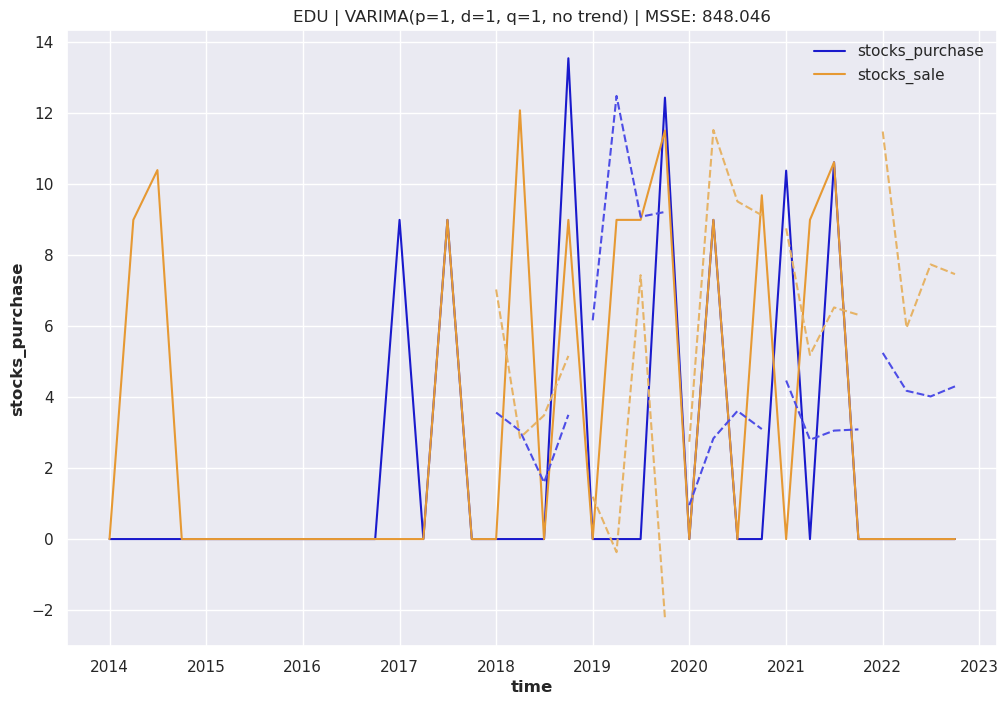

In [142]:
cross_validate_varima("EDU", 1, 1, 1, "n")

298814.47911982087

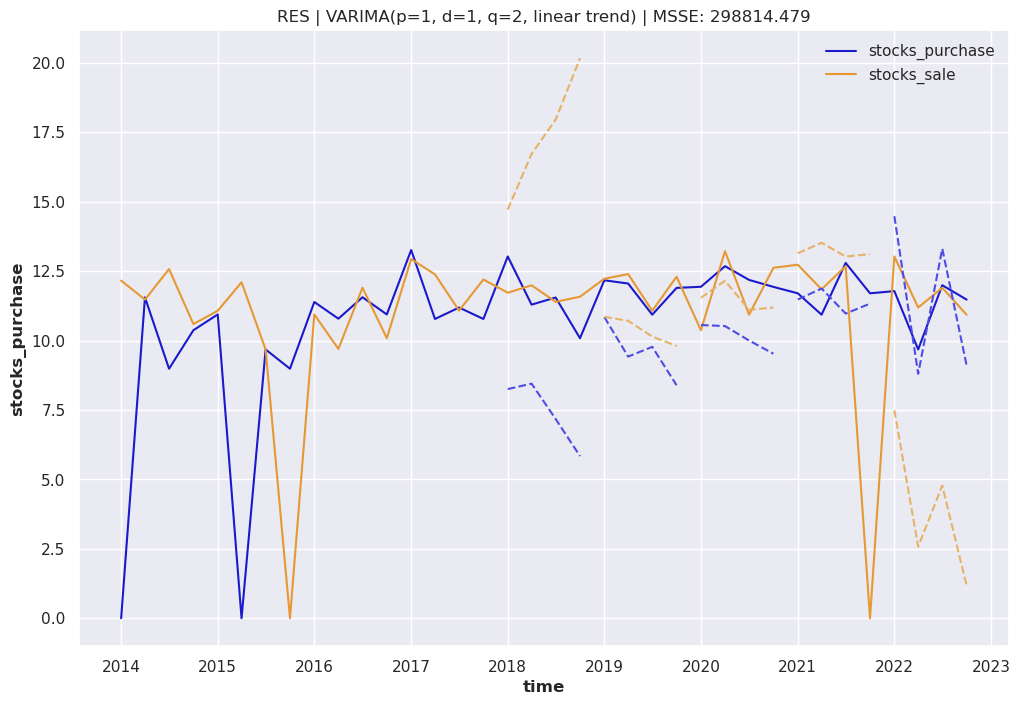

In [144]:
cross_validate_varima("RES", 1, 1, 2, "ct")

0.42467600140902045

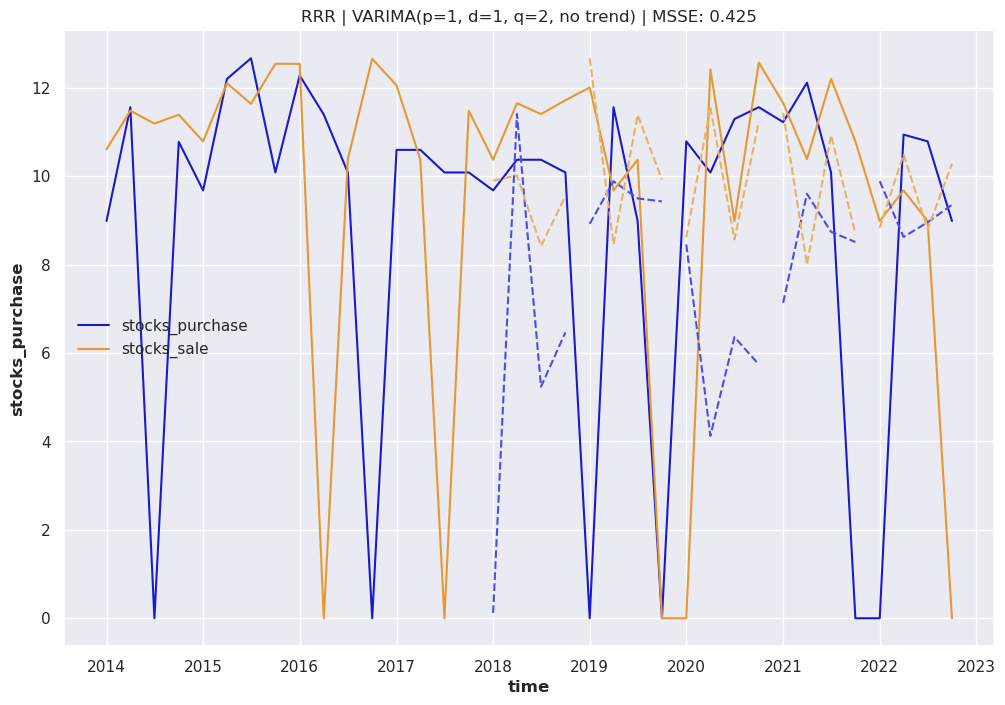

In [145]:
cross_validate_varima("RRR", 1, 1, 2, "n")

Here's a VARIMA model for the unlogged data:

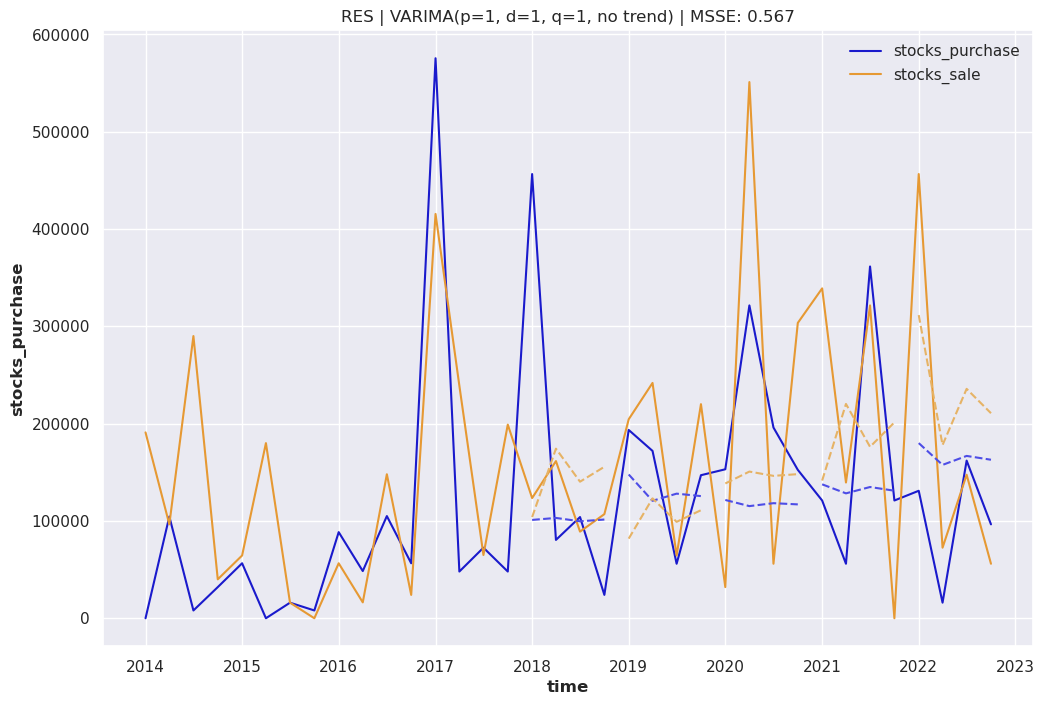

In [146]:

def cross_validate_varima_unlogged(code, p, d, q, trend, plot=True, n_cv=5, test_size=4, **varima_kwargs):

    kf = TimeSeriesSplit(n_splits=n_cv, test_size=test_size)
    code_totals = stock_totals(code2sector.loc[code, "industries"]).iloc[4:]
    X_df = code_totals[["stocks_purchase", "stocks_sale"]]

    if plot:
        fig, ax = plt.subplots(figsize=(12,8))
        sns.lineplot(X_df["stocks_purchase"], linestyle="solid", label="stocks_purchase", color=(0.1, 0.1, 0.8), ax=ax)
        sns.lineplot(X_df["stocks_sale"], linestyle="solid", label="stocks_sale", color=(0.9, 0.6, 0.2), ax=ax)

    MSSE = 0
    for train_idx, valid_idx in kf.split(X_df):
        X_train = TimeSeries.from_dataframe(X_df.iloc[train_idx])
        X_valid = TimeSeries.from_dataframe(X_df.iloc[valid_idx])

        try:
            model = VARIMA(p=p, d=d, q=q, trend=trend).fit(X_train)
        except Exception as e:
            print(f"{code}, {p}, {d}, {q}, {trend_dict[trend]}: {e}")
            return np.nan

        preds = model.predict(len(X_valid))
        MSSE += msse(X_valid, preds, X_train, m=1)
        
        if plot:
            preds_df = preds.pd_dataframe().rename(columns=lambda x: x + "_preds")
            sns.lineplot(preds_df["stocks_purchase_preds"], linestyle="dashed", label=None, color=(0.3, 0.3, 0.9), ax=ax)
            sns.lineplot(preds_df["stocks_sale_preds"], linestyle="dashed", label=None, color=(0.9, 0.7, 0.4), ax=ax)

    MSSE /= kf.get_n_splits()
    if plot:
        plt.title(f"{code} | VARIMA({p=}, {d=}, {q=}, {trend_dict[trend]}) | MSSE: {MSSE:.3f}")
    return MSSE
        
cross_validate_varima_unlogged("RES", 1, 1, 1, "n");

In [147]:
scores_unlogged = pd.DataFrame()
for code in code2sector.index:
    for p in range(3):
        for q in range(3):
            if p == 0 and q == 0:
                continue
            for d, trend in [(0, "ct"), (1, "n")]:
                model_name = f"VARIMA({p=}, {d=}, {q=}, {trend_dict[trend]})"
                scores_unlogged.loc[code, model_name] = cross_validate_varima_unlogged(code, p, d, q, trend, plot=False)
scores_unlogged.style.highlight_min(color="darkblue", axis=1)

/home/pvk/miniconda3/envs/ML/lib/python3.10/site-packages/statsmodels/tsa/statespace/varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/pvk/miniconda3/envs/ML/lib/python3.10/site-packages/statsmodels/tsa/statespace/varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/pvk/miniconda3/envs/ML/lib/python3.10/site-packages/statsmodels/tsa/statespace/varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/pvk/miniconda3/envs/ML/lib/python3.10/site-packages/statsmodels/tsa/statespace/varmax.py:396: UserWarning: Non-stationary starting moving-average parameters found. Using zeros as starting parameters.

GAM, 0, 0, 1, linear trend: Matrix is not positive definite
GAM, 0, 1, 1, no trend: Matrix is not positive definite
GAM, 0, 0, 2, linear trend: Matrix is not positive definite
GAM, 0, 1, 2, no trend: Matrix is not positive definite
GAM, 1, 0, 0, linear trend: Matrix is not positive definite
GAM, 1, 1, 0, no trend: Matrix is not positive definite
GAM, 1, 0, 1, linear trend: Matrix is not positive definite
GAM, 1, 1, 1, no trend: Matrix is not positive definite
GAM, 1, 0, 2, linear trend: Matrix is not positive definite
GAM, 1, 1, 2, no trend: Matrix is not positive definite
GAM, 2, 0, 0, linear trend: Matrix is not positive definite
GAM, 2, 1, 0, no trend: Matrix is not positive definite
GAM, 2, 0, 1, linear trend: Matrix is not positive definite
GAM, 2, 1, 1, no trend: Matrix is not positive definite
GAM, 2, 0, 2, linear trend: Matrix is not positive definite
GAM, 2, 1, 2, no trend: Matrix is not positive definite


/home/pvk/miniconda3/envs/ML/lib/python3.10/site-packages/statsmodels/tsa/statespace/varmax.py:396: UserWarning: Non-stationary starting moving-average parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting moving-average parameters'
/home/pvk/miniconda3/envs/ML/lib/python3.10/site-packages/statsmodels/tsa/statespace/varmax.py:396: UserWarning: Non-stationary starting moving-average parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting moving-average parameters'
/home/pvk/miniconda3/envs/ML/lib/python3.10/site-packages/statsmodels/tsa/statespace/varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/pvk/miniconda3/envs/ML/lib/python3.10/site-packages/statsmodels/tsa/statespace/varmax.py:374: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

,"VARIMA(p=0, d=0, q=1, linear trend)","VARIMA(p=0, d=1, q=1, no trend)","VARIMA(p=0, d=0, q=2, linear trend)","VARIMA(p=0, d=1, q=2, no trend)","VARIMA(p=1, d=0, q=0, linear trend)","VARIMA(p=1, d=1, q=0, no trend)","VARIMA(p=1, d=0, q=1, linear trend)","VARIMA(p=1, d=1, q=1, no trend)","VARIMA(p=1, d=0, q=2, linear trend)","VARIMA(p=1, d=1, q=2, no trend)","VARIMA(p=2, d=0, q=0, linear trend)","VARIMA(p=2, d=1, q=0, no trend)","VARIMA(p=2, d=0, q=1, linear trend)","VARIMA(p=2, d=1, q=1, no trend)","VARIMA(p=2, d=0, q=2, linear trend)","VARIMA(p=2, d=1, q=2, no trend)"
ADV,120.445570,120.245369,120.227649,120.483727,120.715859,120.778631,121.255367,120.865591,120.399837,121.066290,120.475804,121.089148,120.126381,121.609044,121.060553,121.690439
AGR,1.691537,1.757575,1.634829,1.733319,1.718491,2.190658,1.810796,1.776104,2.021854,1.701949,1.708294,1.996144,1.568779,1.638757,1.470382,1.634667
AUT,4.050806,4.353774,4.845657,5.010805,4.367797,4.752423,4.925929,5.297363,4.774525,5.429762,4.710042,4.693477,5.190390,5.375761,4.685027,4.933231
BEV,1.023939,1.222982,1.038006,0.933884,1.041412,0.985953,1.121981,0.841023,0.960121,0.954127,1.136020,1.077216,1.085969,0.973820,0.994854,1.188510
CHM,8.254312,12.188277,7.848312,14.319226,7.450141,20.198252,7.633136,12.697205,7.832620,28.654210,8.722053,7.851018,8.261321,9.127405,8.793716,8.031391
DEF,1.190907,1.405495,1.435316,1.490864,1.220607,1.752903,1.425861,1.485621,1.457961,1.546123,1.383339,1.833961,1.610941,1.735526,1.656624,1.811506
EDU,838.837942,846.584122,839.319845,842.299964,839.297773,846.439245,843.522711,846.230899,839.234436,845.146097,856.387903,845.114280,838.967076,847.003933,840.601459,841.083785
ENG,1.040382,1.188211,1.056668,1.651293,1.037124,1.647516,1.035282,1.165118,1.035591,1.170353,1.091101,1.573744,1.198223,1.178071,1.232939,1.815811
FOO,2.742524,2.819381,2.714749,2.818020,2.771674,2.989007,2.960737,3.172709,2.863758,3.017976,2.943588,3.568124,2.901322,3.157958,2.822834,3.226132
FUE,5.558281,3.814123,5.851429,3.909598,5.407526,3.945079,5.313150,4.668109,5.824675,3.587553,5.218622,3.979807,5.243154,3.824963,5.544655,3.772102


In [151]:
# Do we do better without the logarithm?
scores_unlogged.min(axis=1) < scores.min(axis=1)

ADV     True
AGR     True
AUT     True
BEV     True
CHM    False
DEF     True
EDU     True
ENG    False
FOO    False
FUE    False
GAM    False
INS     True
MAN     True
NAT     True
PHA     True
RES     True
RRR     True
TEC    False
TOB     True
TRU     True
UTI     True
dtype: bool